In [2]:
import pybaseball as pyb 
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
start_date = '2024-03-01'
end_date = '2025-07-01'
statcast_data = pyb.statcast(start_dt=start_date, end_dt=end_date)

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 355/355 [01:04<00:00,  5.49it/s]


In [4]:
pd.set_option('display.max_columns', None)
statcast_data.sample()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
4459,FF,2024-04-09,95.5,-1.71,6.0,"Bednar, David",682985,670280,NaN,ball,<NA>,<NA>,<NA>,<NA>,12,Riley Greene walks.,R,L,R,PIT,DET,B,<NA>,NaN,0,0,2024,-0.51,1.46,0.88,3.25,<NA>,<NA>,<NA>,0,9,Top,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,8.070167,-138.80275,-4.967375,-8.321761,30.329428,-12.302251,3.66,1.72,<NA>,<NA>,<NA>,96.7,2537,7.0,745517,680779,642133,669707,663647,675961,669261,572191,656582,53.51,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,62,1,4-Seam Fastball,3,1,1,3,1,3,1,3,Standard,Standard,206,0.0,0.038,<NA>,<NA>,<NA>,-0.038,<NA>,2,-2,0.929,0.071,29,23,30,24,1,3,3,1,3,3,1.04,0.51,-0.51,40.7,<NA>,<NA>,<NA>,<NA>,<NA>


In [5]:
statcast_data['pitch_type'].unique()

array(['FC', 'SL', 'SI', 'CH', 'FF', 'CU', 'ST', 'KC', 'FS', 'SV', 'PO',
       'KN', 'FA', 'CS', nan, 'EP', 'FO', 'SC'], dtype=object)

In [6]:
from pybaseball import  playerid_lookup
from pybaseball import  statcast_pitcher
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import schedule_and_record

In [7]:
playerid_lookup('kershaw', 'clayton')

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,kershaw,clayton,477132,kersc001,kershcl01,2036,2008.0,2025.0


In [8]:
kershaw_stats = statcast_pitcher('2024-03-01', '2025-07-01', 477132)
kershaw_stats.groupby('pitch_type')

Gathering Player Data


In [9]:
# Group MLB pitchers by a number of metrics
major_grouped = statcast_data.groupby(['pitcher', 'pitch_name']).agg(
    pitcher_name = ('player_name', 'max'),
    handedness = ('p_throws', 'max'),
    count_pitch = ('player_name', 'count'),
    spin_rate = ('release_spin_rate', 'mean'), 
    release_speed = ('release_speed', 'mean'),
    horz_break = ('pfx_x', 'mean'),
    vert_break = ('pfx_z', 'mean'),
    extension = ('release_extension', 'mean'),
    spin_axis = ('spin_axis', 'mean')
).reset_index()

# Adjust pfx_x and pfx_z to inches (i think?)
major_grouped['horz_break'] = major_grouped['horz_break'] * 12
major_grouped['vert_break'] = major_grouped['vert_break'] * 12

#Filter for pitches that have been thrown > 30 times
major_grouped = major_grouped[major_grouped['count_pitch'] > 30].drop(columns = ['count_pitch', 'pitcher'])
major_grouped

,pitch_name,pitcher_name,handedness,spin_rate,release_speed,horz_break,vert_break,extension,spin_axis
0,4-Seam Fastball,"Verlander, Justin",R,2406.92228,93.64789,-8.791443,18.967461,6.022206,207.095485
1,Changeup,"Verlander, Justin",R,1758.83908,84.308429,-13.354023,9.471264,6.048659,229.563218
2,Curveball,"Verlander, Justin",R,2692.281947,77.870791,7.358702,-12.787181,5.997972,38.176471
4,Slider,"Verlander, Justin",R,2453.971284,87.068074,3.912365,6.154865,6.05473,171.753378
5,Sweeper,"Verlander, Justin",R,2596.626667,79.198667,12.8048,-2.4752,6.102667,44.866667
...,...,...,...,...,...,...,...,...,...
5911,4-Seam Fastball,"Bloss, Jake",R,2438.634615,93.365385,-4.813846,18.041538,6.899038,204.711538
5913,Curveball,"Bloss, Jake",R,2700.225806,77.958065,9.170323,-15.886452,6.867742,33.290323
5915,Slider,"Bloss, Jake",R,2533.727273,87.610909,5.312727,6.726545,7.009091,160.636364
5963,4-Seam Fastball,"Fermin, José",R,2306.172662,96.568345,-9.966906,17.115971,6.236691,216.453237


In [10]:
pitch_type = ['4-Seam Fastball',
 'Changeup',
 'Slider',
 'Curveball',
 'Cutter',
 'Sinker',
 'Split-Finger',
 'Sweeper']
pitch_type

['4-Seam Fastball',
 'Changeup',
 'Slider',
 'Curveball',
 'Cutter',
 'Sinker',
 'Split-Finger',
 'Sweeper']

In [11]:
features = ['spin_rate', 'release_speed', 'horz_break', 'vert_break', 'extension', 'spin_axis']

In [12]:
# Create pitcher vector dataframe
final_vectors = []
pitcher_names = []

# Loop over each pitcher
for pitcher_name in major_grouped['pitcher_name'].unique():
    pitcher_data = major_grouped[major_grouped['pitcher_name'] == pitcher_name]
    vec = []

    # For each standard pitch type, grab metrics if it exists
    for pt in pitch_type:
        pitch_row = pitcher_data[pitcher_data['pitch_name'] == pt]
        if not pitch_row.empty:
            vals = pitch_row[features].iloc[0].values  # ensure 1D
        else:
            vals = np.zeros(len(features))  # or np.nan
        vec.extend(vals)

    final_vectors.append(vec)
    pitcher_names.append(pitcher_name)

# Step 3: build column names
column_names = []
for pt in pitch_type:
    for f in features:
        column_names.append(f"{pt}_{f}")

# Step 4: create DataFrame
vectors_df = pd.DataFrame(final_vectors, columns=column_names)
vectors_df.insert(0, 'pitcher', pitcher_names)
vectors_df

,pitcher,4-Seam Fastball_spin_rate,4-Seam Fastball_release_speed,4-Seam Fastball_horz_break,4-Seam Fastball_vert_break,4-Seam Fastball_extension,4-Seam Fastball_spin_axis,Changeup_spin_rate,Changeup_release_speed,Changeup_horz_break,Changeup_vert_break,Changeup_extension,Changeup_spin_axis,Slider_spin_rate,Slider_release_speed,Slider_horz_break,Slider_vert_break,Slider_extension,Slider_spin_axis,Curveball_spin_rate,Curveball_release_speed,Curveball_horz_break,Curveball_vert_break,Curveball_extension,Curveball_spin_axis,Cutter_spin_rate,Cutter_release_speed,Cutter_horz_break,Cutter_vert_break,Cutter_extension,Cutter_spin_axis,Sinker_spin_rate,Sinker_release_speed,Sinker_horz_break,Sinker_vert_break,Sinker_extension,Sinker_spin_axis,Split-Finger_spin_rate,Split-Finger_release_speed,Split-Finger_horz_break,Split-Finger_vert_break,Split-Finger_extension,Split-Finger_spin_axis,Sweeper_spin_rate,Sweeper_release_speed,Sweeper_horz_break,Sweeper_vert_break,Sweeper_extension,Sweeper_spin_axis
0,"Verlander, Justin",2406.922280,93.647890,-8.791443,18.967461,6.022206,207.095485,1758.839080,84.308429,-13.354023,9.471264,6.048659,229.563218,2453.971284,87.068074,3.912365,6.154865,6.054730,171.753378,2692.281947,77.870791,7.358702,-12.787181,5.997972,38.176471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2596.626667,79.198667,12.804800,-2.475200,6.102667,44.866667
1,"Jansen, Kenley",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2430.000000,82.613699,6.816986,-3.516164,6.721918,73.616438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2607.417112,92.308200,4.720107,17.994652,6.806952,176.500891,2283.752137,93.109322,-6.559322,19.381017,6.896610,188.128205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2550.500000,81.313158,14.210526,2.542105,6.678947,61.289474
2,"Chavez, Jesse",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1867.053892,85.014970,-16.016048,1.991856,6.353293,254.479042,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2554.764706,75.455294,15.844235,-8.287059,6.318824,64.176471,2197.945671,88.730390,-1.867029,12.495280,6.250085,213.443124,1982.514019,90.611526,-16.032150,7.563738,6.261682,228.570093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Morton, Charlie",2276.329734,94.096761,-12.934983,11.250498,6.154243,239.963455,2068.697778,85.719333,-16.238400,-0.834667,6.270667,267.253333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3100.727811,81.467751,14.284118,-8.933822,6.086331,61.539053,2461.072072,88.411712,0.247568,5.832432,6.169970,209.744745,2167.939394,93.667532,-17.467013,3.863896,6.165584,244.376623,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Scherzer, Max",2323.250000,92.673058,-9.795146,16.077670,6.230825,222.026699,1392.483607,83.171311,-13.856066,1.928852,6.474590,252.131148,2364.162304,85.309744,4.038769,4.104615,6.235897,165.057592,2673.393939,75.123485,12.990000,-8.140909,6.399242,59.098485,2407.980392,86.582353,3.614118,6.581176,6.105882,194.392157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,"Gibson, Cade",2228.953488,91.923256,9.145116,12.027907,5.995349,139.534884,1952.727273,84.988312,15.565714,1.659740,5.974026,120.012987,2844.604651,85.904651,-2.425116,5.492093,5.913953,194.627907,2957.411215,79.116822,-11.683738,-16.244860,5.855140,322.570093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2256.236559,91.883871,16.802581,8.972903,5.995699,135.20

In [13]:
# Add handedness
mlb_vectors_withhand = vectors_df.merge(major_grouped, left_on = 'pitcher', right_on = 'pitcher_name', how = 'left')
mlb_vectors_withhand = mlb_vectors_withhand.drop(columns = ['pitcher_name', 'pitch_name', 'spin_rate', 'release_speed',	'horz_break', 'vert_break', 'extension', 'spin_axis'])
mlb_vectors_withhand

,pitcher,4-Seam Fastball_spin_rate,4-Seam Fastball_release_speed,4-Seam Fastball_horz_break,4-Seam Fastball_vert_break,4-Seam Fastball_extension,4-Seam Fastball_spin_axis,Changeup_spin_rate,Changeup_release_speed,Changeup_horz_break,Changeup_vert_break,Changeup_extension,Changeup_spin_axis,Slider_spin_rate,Slider_release_speed,Slider_horz_break,Slider_vert_break,Slider_extension,Slider_spin_axis,Curveball_spin_rate,Curveball_release_speed,Curveball_horz_break,Curveball_vert_break,Curveball_extension,Curveball_spin_axis,Cutter_spin_rate,Cutter_release_speed,Cutter_horz_break,Cutter_vert_break,Cutter_extension,Cutter_spin_axis,Sinker_spin_rate,Sinker_release_speed,Sinker_horz_break,Sinker_vert_break,Sinker_extension,Sinker_spin_axis,Split-Finger_spin_rate,Split-Finger_release_speed,Split-Finger_horz_break,Split-Finger_vert_break,Split-Finger_extension,Split-Finger_spin_axis,Sweeper_spin_rate,Sweeper_release_speed,Sweeper_horz_break,Sweeper_vert_break,Sweeper_extension,Sweeper_spin_axis,handedness
0,"Verlander, Justin",2406.922280,93.647890,-8.791443,18.967461,6.022206,207.095485,1758.83908,84.308429,-13.354023,9.471264,6.048659,229.563218,2453.971284,87.068074,3.912365,6.154865,6.054730,171.753378,2692.281947,77.870791,7.358702,-12.787181,5.997972,38.176471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2596.626667,79.198667,12.8048,-2.4752,6.102667,44.866667,R
1,"Verlander, Justin",2406.922280,93.647890,-8.791443,18.967461,6.022206,207.095485,1758.83908,84.308429,-13.354023,9.471264,6.048659,229.563218,2453.971284,87.068074,3.912365,6.154865,6.054730,171.753378,2692.281947,77.870791,7.358702,-12.787181,5.997972,38.176471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2596.626667,79.198667,12.8048,-2.4752,6.102667,44.866667,R
2,"Verlander, Justin",2406.922280,93.647890,-8.791443,18.967461,6.022206,207.095485,1758.83908,84.308429,-13.354023,9.471264,6.048659,229.563218,2453.971284,87.068074,3.912365,6.154865,6.054730,171.753378,2692.281947,77.870791,7.358702,-12.787181,5.997972,38.176471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2596.626667,79.198667,12.8048,-2.4752,6.102667,44.866667,R
3,"Verlander, Justin",2406.922280,93.647890,-8.791443,18.967461,6.022206,207.095485,1758.83908,84.308429,-13.354023,9.471264,6.048659,229.563218,2453.971284,87.068074,3.912365,6.154865,6.054730,171.753378,2692.281947,77.870791,7.358702,-12.787181,5.997972,38.176471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2596.626667,79.198667,12.8048,-2.4752,6.102667,44.866667,R
4,"Verlander, Justin",2406.922280,93.647890,-8.791443,18.967461,6.022206,207.095485,1758.83908,84.308429,-13.354023,9.471264,6.048659,229.563218,2453.971284,87.068074,3.912365,6.154865,6.054730,171.753378,2692.281947,77.870791,7.358702,-12.787181,5.997972,38.176471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2596.626667,79.198667,12.8048,-2.4752,6.102667,44.866667,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3440,"Bloss, Jake",2438.634615,93.365385,-4.813846,18.041538,6.899038,204.711538,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2533.727273,87.610909,5.312727,6.726545,7.009091,160.636364,2700.225806,77.958065,9.170323,-15.886452,6.867742,33.290323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,R
3441,"Bloss, Jake",2438.634615,93.365385,-4.813846,18.041538,6.899038,204.711538,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2533.727273,87.610909,5.312727,6.726545,7.009091,160.636364,2700.225806,77.958065,9.170323,-15.886452,6.867742,33.290323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,R
3442,"Bloss, Jake",2438.634615,93.365385,-4

In [14]:
trackman = pd.read_csv('../../Files/merged_trackman_games.csv')
trackman

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,Runner1st,Runner2nd,Runner3rd,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,base_state,run_exp,count,delta_run_exp,re24
0,1,2/22/25,05:30.1,1,1,"Seid, Spencer",809262,Left,CSD_TRI,"Dumesnil, Nick",8.250940e+05,Right,CAL_LAN,Undefined,1,Top,0,0,0,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0.0,0.0,0.0,0,0,90.64925,0.432719,1.900443,2037.144708,156.551992,11:15,4.87015,-2.27294,5.37321,-16.36367,18.60084,-7.55091,3.91243,-1.11980,81.94319,-2.683311,0.559518,0.425584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.33244,9.52567,2.10803,50.0,4.89779,-4.00496,-131.38274,0.48208,7.51301,29.88203,-15.65521,CSD_TRI,CAL_LAN,UCSanDiego,D1,BW,20250222-UCSanDiego-1,a863ac20-f18a-11ef-9456-e7fd19fa9ca5,88.56641,NaN,NaN,8.70606,NaN,NaN,NaN,NaN,NaN,NaN,f92401d5-ad19-4ab4-801b-f579f4bca033,2/23/25,05:30.1,2025-02-22T18:05:30.0717056-08:00,2025-02-23T02:05:30.0717056Z,NaN,v3,NaN,471762.0,NaN,"Gonzalez, Emiliano",1000081438,Right,CSD_TRI,161a4951-5cb1-4e14-bccc-efd6a6b7a50f,55.12203,-132.54258,14.94101,4.86729,1.08972,-7.82761,2.26914,-4.29657,3.75651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,000/0,0.72,0-0,NaN,-0.0
1,2,2/22/25,05:45.5,1,2,"Seid, Spencer",809262,Left,CSD_TRI,"Dumesnil, Nick",8.250940e+05,Right,CAL_LAN,Undefined,1,Top,0,1,0,Fastball,Sinker,BallCalled,Undefined,Undefined,Undefined,0.0,0.0,0.0,0,0,90.36915,-2.298232,5.488243,1942.903753,126.818131,10:15,4.73413,-2.12090,5.66248,-21.98430,13.10355,-15.85166,0.74802,1.69154,81.89485,-6.411002,2.672846,0.426334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.78292,7.70910,1.66607,50.0,4.52514,-11.85353,-130.49855,-5.99917,16.72644,29.64637,-18.99334,CSD_TRI,CAL_LAN

In [15]:
# Adjust pitch name types to match statcast
def clean_pitch_names(row):
    
    if row['TaggedPitchType'] == 'Splitter':
        row['TaggedPitchType'] = 'Split-Finger'
    if row['TaggedPitchType'] == 'FourSeamFastBall':
        row['TaggedPitchType'] = 'Fastball'
    if row['TaggedPitchType'] == 'ChangeUp':
        row["TaggedPitchType"] = 'Changeup'
    if row['TaggedPitchType'] == 'Fastball':
        row['TaggedPitchType'] = '4-Seam Fastball'
    
    row['HorzBreak'] = row['HorzBreak'] * (-1)
        
    return row

trackman = trackman.apply(clean_pitch_names, axis = 1)
trackman

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,Runner1st,Runner2nd,Runner3rd,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,base_state,run_exp,count,delta_run_exp,re24
0,1,2/22/25,05:30.1,1,1,"Seid, Spencer",809262,Left,CSD_TRI,"Dumesnil, Nick",8.250940e+05,Right,CAL_LAN,Undefined,1,Top,0,0,0,4-Seam Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0.0,0.0,0.0,0,0,90.64925,0.432719,1.900443,2037.144708,156.551992,11:15,4.87015,-2.27294,5.37321,-16.36367,18.60084,7.55091,3.91243,-1.11980,81.94319,-2.683311,0.559518,0.425584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.33244,9.52567,2.10803,50.0,4.89779,-4.00496,-131.38274,0.48208,7.51301,29.88203,-15.65521,CSD_TRI,CAL_LAN,UCSanDiego,D1,BW,20250222-UCSanDiego-1,a863ac20-f18a-11ef-9456-e7fd19fa9ca5,88.56641,NaN,NaN,8.70606,NaN,NaN,NaN,NaN,NaN,NaN,f92401d5-ad19-4ab4-801b-f579f4bca033,2/23/25,05:30.1,2025-02-22T18:05:30.0717056-08:00,2025-02-23T02:05:30.0717056Z,NaN,v3,NaN,471762.0,NaN,"Gonzalez, Emiliano",1000081438,Right,CSD_TRI,161a4951-5cb1-4e14-bccc-efd6a6b7a50f,55.12203,-132.54258,14.94101,4.86729,1.08972,-7.82761,2.26914,-4.29657,3.75651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,000/0,0.72,0-0,NaN,-0.0
1,2,2/22/25,05:45.5,1,2,"Seid, Spencer",809262,Left,CSD_TRI,"Dumesnil, Nick",8.250940e+05,Right,CAL_LAN,Undefined,1,Top,0,1,0,4-Seam Fastball,Sinker,BallCalled,Undefined,Undefined,Undefined,0.0,0.0,0.0,0,0,90.36915,-2.298232,5.488243,1942.903753,126.818131,10:15,4.73413,-2.12090,5.66248,-21.98430,13.10355,15.85166,0.74802,1.69154,81.89485,-6.411002,2.672846,0.426334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.78292,7.70910,1.66607,50.0,4.52514,-11.85353,-130.49855,-5.99917,16.72644,29.64637,-18.99334,CSD

In [16]:
# Group by ucsd pitcher and various metrics
ucsd = trackman[trackman['PitcherTeam'] == "CSD_TRI"].groupby(['Pitcher', 'TaggedPitchType']).agg(
    handedness = ('PitcherThrows', 'max'),
    count_pitch = ('TaggedPitchType', 'count'),
    release_speed = ('RelSpeed', 'mean'),
    spin_rate = ('SpinRate', 'mean'),
    spin_axis = ('SpinAxis', 'mean'),
    extension = ('Extension', 'mean'),
    vert_break = ('InducedVertBreak', 'mean'),
    horz_break = ('HorzBreak', 'mean')
).reset_index()

ucsd = ucsd[ucsd['count_pitch'] > 8]
ucsd

,Pitcher,TaggedPitchType,handedness,count_pitch,release_speed,spin_rate,spin_axis,extension,vert_break,horz_break
0,"Cazares, Julian",4-Seam Fastball,Left,66,88.471789,2151.435786,164.676380,5.843351,18.680750,4.907465
1,"Cazares, Julian",Changeup,Left,11,79.701473,1754.774606,95.453819,4.922805,3.857876,17.701775
4,"Cazares, Julian",Slider,Left,42,79.361717,2349.437108,267.437374,5.162385,-0.939638,-3.670663
9,"Dalquist, Matthew",4-Seam Fastball,Right,390,88.917354,2428.225993,202.826777,5.742637,20.117488,-8.213400
10,"Dalquist, Matthew",Changeup,Right,91,79.465425,1781.151688,253.207777,5.812097,5.499094,-15.234964
...,...,...,...,...,...,...,...,...,...,...
94,"Villar, Jake",Sinker,Left,47,85.483072,2168.623190,123.516458,5.156891,10.306133,13.589755
95,"Villar, Jake",Slider,Left,142,78.654628,2188.153356,277.418471,4.770237,-0.179325,-8.444508
96,"Villar, Jake",Sweeper,Left,24,78.741176,2277.967680,276.632578,5.070667,0.548352,-10.121163
97,"Weber, Chapman",4-Seam Fastball,Right,236,89.697219,2265.244352,203.660116,5.122914,23.956657,-10.018547


In [17]:
pitch_type_ucsd = list(ucsd['TaggedPitchType'].unique())
pitch_type_ucsd

['4-Seam Fastball',
 'Changeup',
 'Slider',
 'Curveball',
 'Cutter',
 'Sinker',
 'Split-Finger',
 'Sweeper']

In [18]:
features_ucsd = ['release_speed', 'spin_rate', 'spin_axis', 'extension', 'vert_break', 'horz_break']

In [19]:
final_vectors = []
pitcher_names = []

# Loop over each pitcher
for pitcher_name in ucsd['Pitcher'].unique():
    pitcher_data = ucsd[ucsd['Pitcher'] == pitcher_name]
    vec = []

    # For each standard pitch type, grab metrics if it exists
    for pt in pitch_type_ucsd:
        pitch_row = pitcher_data[pitcher_data['TaggedPitchType'] == pt]
        if not pitch_row.empty:
            vals = pitch_row[features_ucsd].iloc[0].values  # ensure 1D
        else:
            vals = np.zeros(len(features))  # or np.nan
        vec.extend(vals)

    final_vectors.append(vec)
    pitcher_names.append(pitcher_name)

# Step 3: build column names
column_names = []
for pt in pitch_type_ucsd:
    for f in features_ucsd:
        column_names.append(f"{pt}_{f}")

# Step 4: create DataFrame
ucsd_vectors = pd.DataFrame(final_vectors, columns=column_names)
ucsd_vectors.insert(0, 'pitcher', pitcher_names)
ucsd_vectors

,pitcher,4-Seam Fastball_release_speed,4-Seam Fastball_spin_rate,4-Seam Fastball_spin_axis,4-Seam Fastball_extension,4-Seam Fastball_vert_break,4-Seam Fastball_horz_break,Changeup_release_speed,Changeup_spin_rate,Changeup_spin_axis,Changeup_extension,Changeup_vert_break,Changeup_horz_break,Slider_release_speed,Slider_spin_rate,Slider_spin_axis,Slider_extension,Slider_vert_break,Slider_horz_break,Curveball_release_speed,Curveball_spin_rate,Curveball_spin_axis,Curveball_extension,Curveball_vert_break,Curveball_horz_break,Cutter_release_speed,Cutter_spin_rate,Cutter_spin_axis,Cutter_extension,Cutter_vert_break,Cutter_horz_break,Sinker_release_speed,Sinker_spin_rate,Sinker_spin_axis,Sinker_extension,Sinker_vert_break,Sinker_horz_break,Split-Finger_release_speed,Split-Finger_spin_rate,Split-Finger_spin_axis,Split-Finger_extension,Split-Finger_vert_break,Split-Finger_horz_break,Sweeper_release_speed,Sweeper_spin_rate,Sweeper_spin_axis,Sweeper_extension,Sweeper_vert_break,Sweeper_horz_break
0,"Cazares, Julian",88.471789,2151.435786,164.676380,5.843351,18.680750,4.907465,79.701473,1754.774606,95.453819,4.922805,3.857876,17.701775,79.361717,2349.437108,267.437374,5.162385,-0.939638,-3.670663,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,"Dalquist, Matthew",88.917354,2428.225993,202.826777,5.742637,20.117488,-8.213400,79.465425,1781.151688,253.207777,5.812097,5.499094,-15.234964,82.720486,2447.634032,113.902140,5.161007,3.741759,5.824260,74.926023,2459.541861,44.089341,5.139454,-10.852446,12.105688,83.199194,2488.615077,125.433412,5.413208,5.026725,5.189934,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,"Davidson, Garrett",85.661506,2146.994880,154.427683,4.903740,15.957478,7.336815,77.308087,1515.452132,95.027869,4.959643,2.559521,14.410717,74.155766,2276.647706,280.535485,4.491794,-5.350577,-9.668084,71.310709,2357.390834,291.703567,4.155051,-8.962203,-14.695104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,"Ernisse, Zach",88.736867,2188.778474,164.486918,5.927394,23.291826,6.075582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,81.042626,2379.753928,276.029631,5.293233,0.234685,-6.669285,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,"Gregson, Niccolas",89.617333,2255.416915,197.737886,6.341022,18.939651,-5.994221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,82.411034,2528.056539,115.903588,5.903371,3.448766,2.824657,74.969531,2815.166014,32.382876,5.745636,-15.135522,8.280808,84.007924,2394.278370,179.781303,6.390396,8.141304,-0.327554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
5,"Hasegawa, Sam",89.421907,2416.848309,184.654447,5.663910,10.826143,-0.400802,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,81.452536,2502.029758,283.178014,5.508476,-1.787087,-9.056739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,89.132758,2406.797889,187.684837,6.128570,11.572052,-1.267020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
6,"Huy, Nathan",85.530805,1922.655264,180.828451,5.413591,12.213211,0.511295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.788416,2253.

In [20]:
ucsd_vectors_withhand = ucsd_vectors.merge(ucsd, left_on = 'pitcher', right_on = 'Pitcher', how = 'left')
ucsd_vectors_withhand = ucsd_vectors_withhand.drop(columns = ['TaggedPitchType', 'Pitcher', 'count_pitch', 'release_speed', 'spin_rate', 'spin_axis', 'extension', 'vert_break', 'horz_break'])
ucsd_vectors_withhand

,pitcher,4-Seam Fastball_release_speed,4-Seam Fastball_spin_rate,4-Seam Fastball_spin_axis,4-Seam Fastball_extension,4-Seam Fastball_vert_break,4-Seam Fastball_horz_break,Changeup_release_speed,Changeup_spin_rate,Changeup_spin_axis,Changeup_extension,Changeup_vert_break,Changeup_horz_break,Slider_release_speed,Slider_spin_rate,Slider_spin_axis,Slider_extension,Slider_vert_break,Slider_horz_break,Curveball_release_speed,Curveball_spin_rate,Curveball_spin_axis,Curveball_extension,Curveball_vert_break,Curveball_horz_break,Cutter_release_speed,Cutter_spin_rate,Cutter_spin_axis,Cutter_extension,Cutter_vert_break,Cutter_horz_break,Sinker_release_speed,Sinker_spin_rate,Sinker_spin_axis,Sinker_extension,Sinker_vert_break,Sinker_horz_break,Split-Finger_release_speed,Split-Finger_spin_rate,Split-Finger_spin_axis,Split-Finger_extension,Split-Finger_vert_break,Split-Finger_horz_break,Sweeper_release_speed,Sweeper_spin_rate,Sweeper_spin_axis,Sweeper_extension,Sweeper_vert_break,Sweeper_horz_break,handedness
0,"Cazares, Julian",88.471789,2151.435786,164.676380,5.843351,18.680750,4.907465,79.701473,1754.774606,95.453819,4.922805,3.857876,17.701775,79.361717,2349.437108,267.437374,5.162385,-0.939638,-3.670663,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,Left
1,"Cazares, Julian",88.471789,2151.435786,164.676380,5.843351,18.680750,4.907465,79.701473,1754.774606,95.453819,4.922805,3.857876,17.701775,79.361717,2349.437108,267.437374,5.162385,-0.939638,-3.670663,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,Left
2,"Cazares, Julian",88.471789,2151.435786,164.676380,5.843351,18.680750,4.907465,79.701473,1754.774606,95.453819,4.922805,3.857876,17.701775,79.361717,2349.437108,267.437374,5.162385,-0.939638,-3.670663,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,Left
3,"Dalquist, Matthew",88.917354,2428.225993,202.826777,5.742637,20.117488,-8.213400,79.465425,1781.151688,253.207777,5.812097,5.499094,-15.234964,82.720486,2447.634032,113.902140,5.161007,3.741759,5.824260,74.926023,2459.541861,44.089341,5.139454,-10.852446,12.105688,83.199194,2488.615077,125.433412,5.413208,5.026725,5.189934,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,Right
4,"Dalquist, Matthew",88.917354,2428.225993,202.826777,5.742637,20.117488,-8.213400,79.465425,1781.151688,253.207777,5.812097,5.499094,-15.234964,82.720486,2447.634032,113.902140,5.161007,3.741759,5.824260,74.926023,2459.541861,44.089341,5.139454,-10.852446,12.105688,83.199194,2488.615077,125.433412,5.413208,5.026725,5.189934,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,Right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,"Villar, Jake",85.682666,2159.920294,147.640075,5.568090,12.602043,6.992488,77.891877,1584.741558,128.733564,5.510417,8.661711,10.245849,78.654628,2188.153356,277.418471,4.770237,-0.179325,-8.444508,77.251492,1995.569223,289.249605,4.506115,-7.865252,-9.168466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,85.483072,2168.62319,123.516458,5.156891,10.306133,13.589755,0.0,0.0,0.0,0.0,0.0,0.0,78.741176,2277.96768,276.632578,5.070667,0.548352,-10.121163,Left
57,"Villar, Jake",85.682666,2159.920294,147.640075,

In [21]:
mlb_vectors_withhand

,pitcher,4-Seam Fastball_spin_rate,4-Seam Fastball_release_speed,4-Seam Fastball_horz_break,4-Seam Fastball_vert_break,4-Seam Fastball_extension,4-Seam Fastball_spin_axis,Changeup_spin_rate,Changeup_release_speed,Changeup_horz_break,Changeup_vert_break,Changeup_extension,Changeup_spin_axis,Slider_spin_rate,Slider_release_speed,Slider_horz_break,Slider_vert_break,Slider_extension,Slider_spin_axis,Curveball_spin_rate,Curveball_release_speed,Curveball_horz_break,Curveball_vert_break,Curveball_extension,Curveball_spin_axis,Cutter_spin_rate,Cutter_release_speed,Cutter_horz_break,Cutter_vert_break,Cutter_extension,Cutter_spin_axis,Sinker_spin_rate,Sinker_release_speed,Sinker_horz_break,Sinker_vert_break,Sinker_extension,Sinker_spin_axis,Split-Finger_spin_rate,Split-Finger_release_speed,Split-Finger_horz_break,Split-Finger_vert_break,Split-Finger_extension,Split-Finger_spin_axis,Sweeper_spin_rate,Sweeper_release_speed,Sweeper_horz_break,Sweeper_vert_break,Sweeper_extension,Sweeper_spin_axis,handedness
0,"Verlander, Justin",2406.922280,93.647890,-8.791443,18.967461,6.022206,207.095485,1758.83908,84.308429,-13.354023,9.471264,6.048659,229.563218,2453.971284,87.068074,3.912365,6.154865,6.054730,171.753378,2692.281947,77.870791,7.358702,-12.787181,5.997972,38.176471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2596.626667,79.198667,12.8048,-2.4752,6.102667,44.866667,R
1,"Verlander, Justin",2406.922280,93.647890,-8.791443,18.967461,6.022206,207.095485,1758.83908,84.308429,-13.354023,9.471264,6.048659,229.563218,2453.971284,87.068074,3.912365,6.154865,6.054730,171.753378,2692.281947,77.870791,7.358702,-12.787181,5.997972,38.176471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2596.626667,79.198667,12.8048,-2.4752,6.102667,44.866667,R
2,"Verlander, Justin",2406.922280,93.647890,-8.791443,18.967461,6.022206,207.095485,1758.83908,84.308429,-13.354023,9.471264,6.048659,229.563218,2453.971284,87.068074,3.912365,6.154865,6.054730,171.753378,2692.281947,77.870791,7.358702,-12.787181,5.997972,38.176471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2596.626667,79.198667,12.8048,-2.4752,6.102667,44.866667,R
3,"Verlander, Justin",2406.922280,93.647890,-8.791443,18.967461,6.022206,207.095485,1758.83908,84.308429,-13.354023,9.471264,6.048659,229.563218,2453.971284,87.068074,3.912365,6.154865,6.054730,171.753378,2692.281947,77.870791,7.358702,-12.787181,5.997972,38.176471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2596.626667,79.198667,12.8048,-2.4752,6.102667,44.866667,R
4,"Verlander, Justin",2406.922280,93.647890,-8.791443,18.967461,6.022206,207.095485,1758.83908,84.308429,-13.354023,9.471264,6.048659,229.563218,2453.971284,87.068074,3.912365,6.154865,6.054730,171.753378,2692.281947,77.870791,7.358702,-12.787181,5.997972,38.176471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2596.626667,79.198667,12.8048,-2.4752,6.102667,44.866667,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3440,"Bloss, Jake",2438.634615,93.365385,-4.813846,18.041538,6.899038,204.711538,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2533.727273,87.610909,5.312727,6.726545,7.009091,160.636364,2700.225806,77.958065,9.170323,-15.886452,6.867742,33.290323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,R
3441,"Bloss, Jake",2438.634615,93.365385,-4.813846,18.041538,6.899038,204.711538,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2533.727273,87.610909,5.312727,6.726545,7.009091,160.636364,2700.225806,77.958065,9.170323,-15.886452,6.867742,33.290323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,R
3442,"Bloss, Jake",2438.634615,93.365385,-4

In [22]:
# Encode handedness for KNN model (Left = 0, Right = 1)
def encode_handedness(row):
    
    if (row['handedness'] == 'R') | (row['handedness'] == 'Right'):
        row['handedness'] = 1
    if (row['handedness'] == 'L') | (row['handedness'] == 'Left'):
        row['handedness'] = 0
        
    return row

mlb_vectors_withhand = mlb_vectors_withhand.apply(encode_handedness, axis = 1).copy().drop_duplicates(subset = 'pitcher')
ucsd_vectors_withhand = ucsd_vectors_withhand.apply(encode_handedness, axis = 1).copy().drop_duplicates(subset = 'pitcher')
display(ucsd_vectors_withhand)

#Spoiler, steele is compared to bello
display(mlb_vectors_withhand[mlb_vectors_withhand['pitcher'] == 'Bello, Brayan'])

,pitcher,4-Seam Fastball_release_speed,4-Seam Fastball_spin_rate,4-Seam Fastball_spin_axis,4-Seam Fastball_extension,4-Seam Fastball_vert_break,4-Seam Fastball_horz_break,Changeup_release_speed,Changeup_spin_rate,Changeup_spin_axis,Changeup_extension,Changeup_vert_break,Changeup_horz_break,Slider_release_speed,Slider_spin_rate,Slider_spin_axis,Slider_extension,Slider_vert_break,Slider_horz_break,Curveball_release_speed,Curveball_spin_rate,Curveball_spin_axis,Curveball_extension,Curveball_vert_break,Curveball_horz_break,Cutter_release_speed,Cutter_spin_rate,Cutter_spin_axis,Cutter_extension,Cutter_vert_break,Cutter_horz_break,Sinker_release_speed,Sinker_spin_rate,Sinker_spin_axis,Sinker_extension,Sinker_vert_break,Sinker_horz_break,Split-Finger_release_speed,Split-Finger_spin_rate,Split-Finger_spin_axis,Split-Finger_extension,Split-Finger_vert_break,Split-Finger_horz_break,Sweeper_release_speed,Sweeper_spin_rate,Sweeper_spin_axis,Sweeper_extension,Sweeper_vert_break,Sweeper_horz_break,handedness
0,"Cazares, Julian",88.471789,2151.435786,164.676380,5.843351,18.680750,4.907465,79.701473,1754.774606,95.453819,4.922805,3.857876,17.701775,79.361717,2349.437108,267.437374,5.162385,-0.939638,-3.670663,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0
3,"Dalquist, Matthew",88.917354,2428.225993,202.826777,5.742637,20.117488,-8.213400,79.465425,1781.151688,253.207777,5.812097,5.499094,-15.234964,82.720486,2447.634032,113.902140,5.161007,3.741759,5.824260,74.926023,2459.541861,44.089341,5.139454,-10.852446,12.105688,83.199194,2488.615077,125.433412,5.413208,5.026725,5.189934,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1
8,"Davidson, Garrett",85.661506,2146.994880,154.427683,4.903740,15.957478,7.336815,77.308087,1515.452132,95.027869,4.959643,2.559521,14.410717,74.155766,2276.647706,280.535485,4.491794,-5.350577,-9.668084,71.310709,2357.390834,291.703567,4.155051,-8.962203,-14.695104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0
12,"Ernisse, Zach",88.736867,2188.778474,164.486918,5.927394,23.291826,6.075582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,81.042626,2379.753928,276.029631,5.293233,0.234685,-6.669285,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0
14,"Gregson, Niccolas",89.617333,2255.416915,197.737886,6.341022,18.939651,-5.994221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,82.411034,2528.056539,115.903588,5.903371,3.448766,2.824657,74.969531,2815.166014,32.382876,5.745636,-15.135522,8.280808,84.007924,2394.278370,179.781303,6.390396,8.141304,-0.327554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1
18,"Hasegawa, Sam",89.421907,2416.848309,184.654447,5.663910,10.826143,-0.400802,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,81.452536,2502.029758,283.178014,5.508476,-1.787087,-9.056739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,89.132758,2406.797889,187.684837,6.128570,11.572052,-1.267020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0
21,"Huy, Nathan",85.530805,1922.655264,180.828451,5.413591,12.213211,0.511295,0.000000,0.000000,0.000000,0.000000,0.0000

,pitcher,4-Seam Fastball_spin_rate,4-Seam Fastball_release_speed,4-Seam Fastball_horz_break,4-Seam Fastball_vert_break,4-Seam Fastball_extension,4-Seam Fastball_spin_axis,Changeup_spin_rate,Changeup_release_speed,Changeup_horz_break,Changeup_vert_break,Changeup_extension,Changeup_spin_axis,Slider_spin_rate,Slider_release_speed,Slider_horz_break,Slider_vert_break,Slider_extension,Slider_spin_axis,Curveball_spin_rate,Curveball_release_speed,Curveball_horz_break,Curveball_vert_break,Curveball_extension,Curveball_spin_axis,Cutter_spin_rate,Cutter_release_speed,Cutter_horz_break,Cutter_vert_break,Cutter_extension,Cutter_spin_axis,Sinker_spin_rate,Sinker_release_speed,Sinker_horz_break,Sinker_vert_break,Sinker_extension,Sinker_spin_axis,Split-Finger_spin_rate,Split-Finger_release_speed,Split-Finger_horz_break,Split-Finger_vert_break,Split-Finger_extension,Split-Finger_spin_axis,Sweeper_spin_rate,Sweeper_release_speed,Sweeper_horz_break,Sweeper_vert_break,Sweeper_extension,Sweeper_spin_axis,handedness
2634,"Bello, Brayan",2180.79257,95.210526,-8.273355,13.035789,6.354799,226.003096,1806.034627,87.918888,-16.057764,3.242644,6.418783,249.002099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2515.630631,88.582883,0.787027,2.784865,6.382883,166.207207,2072.633415,95.504162,-17.098338,4.277552,6.358078,233.366585,0.0,0.0,0.0,0.0,0.0,0.0,2395.497137,86.498187,8.588621,-1.22187,6.251289,41.419847,1


In [23]:
from sklearn.preprocessing import StandardScaler

x_ucsd = ucsd_vectors_withhand.drop(columns = ['pitcher']).copy().drop_duplicates(subset = '4-Seam Fastball_release_speed')
x_mlb = mlb_vectors_withhand.drop(columns = ['pitcher']).copy().drop_duplicates(subset = '4-Seam Fastball_release_speed')

scaler = StandardScaler()
x_all = pd.concat([x_ucsd, x_mlb], axis = 0)
x_all_scaled = scaler.fit_transform(x_all)

x_mlb_scaled = x_all_scaled[:len(x_mlb)]
x_ucsd_scaled = x_all_scaled[len(x_mlb):]

In [24]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors = 10, metric = 'euclidean')
knn.fit(x_mlb_scaled)

distances, indices = knn.kneighbors(x_ucsd_scaled)

results = []

for i, (dists, idxs) in enumerate(zip(distances, indices)):
    team_pitcher = ucsd_vectors_withhand.iloc[i]['pitcher']
    for rank, (dist, idx) in enumerate(zip(dists, idxs), start=1):
        mlb_pitcher = mlb_vectors_withhand.iloc[idx]['pitcher']
        results.append({
            'Team Pitcher': team_pitcher,
            'Similar MLB Pitcher': mlb_pitcher,
            'Similarity Rank': rank,
            'Distance': dist
        })

top10_df = pd.DataFrame(results)
top10_df[top10_df['Similarity Rank'] == 1]

,Team Pitcher,Similar MLB Pitcher,Similarity Rank,Distance
0,"Cazares, Julian","Smith, Cade",1,2.350211
10,"Dalquist, Matthew","Thompson, Keegan",1,2.825474
20,"Davidson, Garrett","Hill, Jaden",1,1.565082
30,"Ernisse, Zach","Mattson, Isaac",1,2.405401
40,"Gregson, Niccolas","Herget, Kevin",1,1.279899
50,"Hasegawa, Sam","Montgomery, Mason",1,3.098777
60,"Huy, Nathan","Rasmussen, Drew",1,1.932304
70,"King, Devon","Hahn, Jesse",1,1.215358
80,"Marchetti, Landon","Cruz, Fernando",1,3.013424
90,"Murdock, Steele","Fernandez, Ryan",1,2.072634


In [132]:
def find_similar_pitchers(
    team_df: pd.DataFrame,
    mlb_df: pd.DataFrame,
    team_vectors_df: pd.DataFrame,
    mlb_vectors_df: pd.DataFrame,
    team_pitcher_name: str,
    n_neighbors: int = 3
) -> pd.DataFrame:
    
    
   # Get rid of duplicates in team_df
    
   # --- 1. Get pitch types for the team pitcher
    team_pitch_types = set(team_df[team_df['Pitcher'] == team_pitcher_name]['TaggedPitchType'].unique())

    # --- 2. Map MLB pitchers to their pitch types
    mlb_pitch_types_by_pitcher = mlb_df.groupby('pitcher_name')['pitch_name'].apply(set).to_dict()

    # --- 3. Filter MLB pitchers who throw at least all the same pitch types
    compatible_mlb_pitchers = [
        p for p, pitches in mlb_pitch_types_by_pitcher.items()
        if team_pitch_types.issubset(pitches)
    ]

    # --- 4. Subset MLB vectors to compatible pitchers
    mlb_filtered_vectors = mlb_vectors_df[mlb_vectors_df['pitcher'].isin(compatible_mlb_pitchers)]
    if mlb_filtered_vectors.empty:
        raise ValueError(f"No MLB pitchers found with compatible pitch types for {team_pitcher_name}.")
    

    # --- 5. Get team vector
    team_vector_row = team_vectors_df[team_vectors_df['pitcher'] == team_pitcher_name]
    if team_vector_row.empty:
        raise ValueError(f"Pitcher '{team_pitcher_name}' not found in team_vectors_df.")
    team_vector = team_vector_row.drop(columns='pitcher').values
    
    
    # ---- Filter for handedness
    handedness = team_vector_row['handedness'].iloc[0]
    mlb_filtered_hand = mlb_filtered_vectors[mlb_filtered_vectors['handedness'] == handedness]
    if mlb_filtered_hand.empty:
        raise ValueError(f"No MLB pitchers found with compatible pitch types for {team_pitcher_name}.")

    # --- 6. Scale both MLB and team vectors
    X_mlb = mlb_filtered_hand.drop(columns='pitcher').values
    X_all = np.vstack([X_mlb, team_vector])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_all)
    X_mlb_scaled = X_scaled[:-1]
    X_team_scaled = X_scaled[-1].reshape(1, -1)

    # --- 7. Fit KNN
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(X_mlb_scaled)
    distances, indices = knn.kneighbors(X_team_scaled)

    # --- 8. Return results
    similar_pitchers = mlb_filtered_hand.iloc[indices[0]].copy()
    similar_pitchers['distance'] = distances[0]
    
    return similar_pitchers.reset_index(drop=True)




weber_comparison = find_similar_pitchers(
    team_df = ucsd,
    mlb_df = major_grouped,
    team_vectors_df=  ucsd_vectors_withhand,
    mlb_vectors_df = mlb_vectors_withhand,
    team_pitcher_name='Weber, Chapman',
    n_neighbors = 10
)

display(weber_comparison)

,pitcher,4-Seam Fastball_spin_rate,4-Seam Fastball_release_speed,4-Seam Fastball_horz_break,4-Seam Fastball_vert_break,4-Seam Fastball_extension,4-Seam Fastball_spin_axis,Changeup_spin_rate,Changeup_release_speed,Changeup_horz_break,Changeup_vert_break,Changeup_extension,Changeup_spin_axis,Slider_spin_rate,Slider_release_speed,Slider_horz_break,Slider_vert_break,Slider_extension,Slider_spin_axis,Curveball_spin_rate,Curveball_release_speed,Curveball_horz_break,Curveball_vert_break,Curveball_extension,Curveball_spin_axis,Cutter_spin_rate,Cutter_release_speed,Cutter_horz_break,Cutter_vert_break,Cutter_extension,Cutter_spin_axis,Sinker_spin_rate,Sinker_release_speed,Sinker_horz_break,Sinker_vert_break,Sinker_extension,Sinker_spin_axis,Split-Finger_spin_rate,Split-Finger_release_speed,Split-Finger_horz_break,Split-Finger_vert_break,Split-Finger_extension,Split-Finger_spin_axis,Sweeper_spin_rate,Sweeper_release_speed,Sweeper_horz_break,Sweeper_vert_break,Sweeper_extension,Sweeper_spin_axis,handedness,distance
0,"Honeywell, Brent",2147.954198,94.688804,-5.680000,16.162137,6.124173,203.277354,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,2369.329730,85.860541,7.814919,2.955243,6.199459,132.616216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,47.568881
1,"Bradish, Kyle",2396.877778,94.517778,2.780000,13.934667,6.601111,181.277778,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,2649.631841,88.231343,11.803582,-0.173134,6.521891,56.577114,2625.750000,84.055172,4.321034,-11.659655,6.488793,23.982759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2193.704120,95.299251,-10.831011,13.364944,6.608240,191.722846,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,47.607265
2,"Pallante, Andre",2265.461538,94.441824,-0.291635,9.794010,6.574182,185.539610,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,2384.992000,87.559333,4.987360,-0.950240,6.678800,101.278667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2141.876442,94.847862,-10.306776,14.299145,6.575493,194.739703,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,47.609876
3,"Church, Marc",2130.206349,96.306349,-2.731429,17.895238,6.817460,196.857143,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,2089.134328,87.156716,2.527164,5.007761,6.756716,175.522388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,47.625096
4,"Burr, Ryan",2179.392857,94.083036,-1.003393,16.774821,6.979464,193.772321,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,2542.092754,85.369565,4.813565,-1.953043,6.902319,80.533333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,47.693721
5,"Granillo, Andre",2225.945946,94.681081,-2.883243,15.930811,6.170270,199.729730,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,2281.151899,83.698734,1.060253,4.174177,5.993671,113.721519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,47.751482
6,"Tyler, Kyle",2107.463415,90.628049,-7.360976,11.789268,6.974390,178.780488,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,2494.246154,82.186154,10.825846,0.127385,6.980000,52.461538,2425.842424,76.995758,6.962182,-13.886545,6.921212,23.096970,2215.734615,90.301538,5.740615,10.362462,6.928077,168.7269

## Plotting Pitch Plots

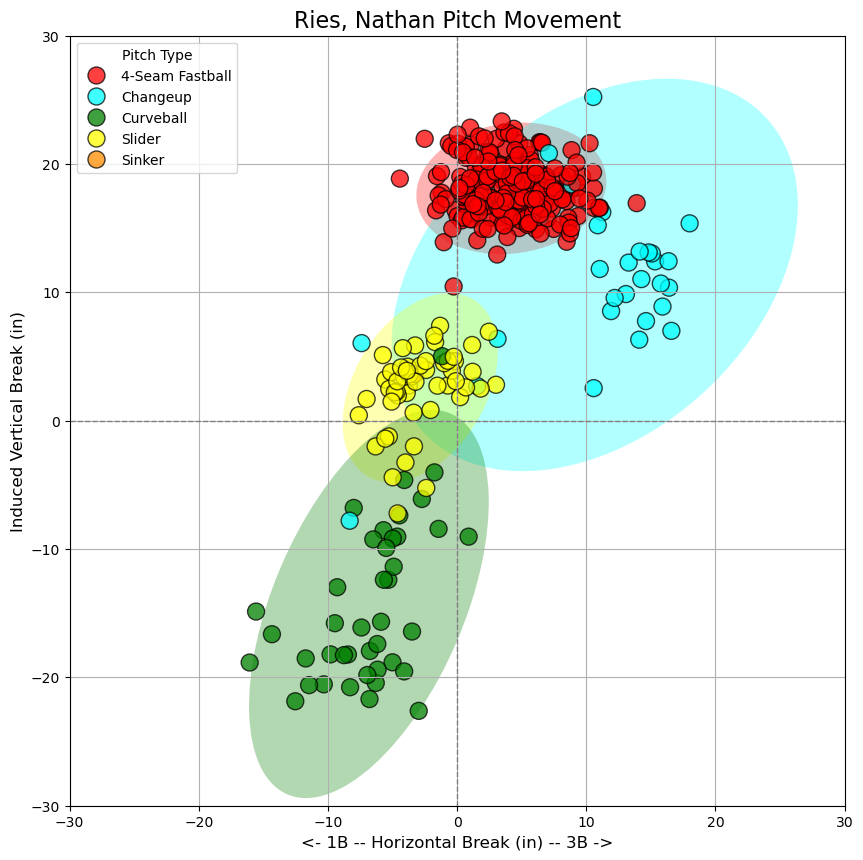

In [97]:
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def plot_ucsd_pitcher(pitcher):

    plotting_df = trackman[trackman['Pitcher'] == pitcher][['TaggedPitchType', 'InducedVertBreak', 'HorzBreak']]
    plotting_df['HorzBreak'] = plotting_df['HorzBreak'] * (-1)

    color_map = {
        '4-Seam Fastball': 'red',
        'Sinker': 'darkorange',
        'Changeup': 'cyan',
        'Slider': 'yellow',
        'Curveball': 'green',
        'Split-Finger': 'brown',
        'Other': 'gray',
        'Sweeper': 'purple',
        'Cutter': 'teal'
    }

    plt.figure(figsize = (10, 10))
    ax = plt.gca()


    sns.scatterplot(
        data = plotting_df, 
        x = 'HorzBreak',
        y = 'InducedVertBreak',
        hue = 'TaggedPitchType',
        palette = color_map,
        edgecolor = 'black',
        s = 150,
        alpha = 0.75,
        zorder = 1
    )

    def draw_ellipse(data, ax, color, label=None):
        if len(data) < 5:
            return  
        
        cov = np.cov(data.T)
        mean = np.mean(data, axis=0)
        
        lambda_, v = np.linalg.eig(cov)
        lambda_ = np.sqrt(lambda_)
        
        scale_factor = 2.45
        ell = Ellipse(
            xy=mean,
            width=scale_factor * lambda_[0] * 2,
            height=scale_factor * lambda_[1] * 2,
            angle=np.rad2deg(np.arccos(v[0, 0])),
            edgecolor=color,
            facecolor=color,
            alpha=0.3,
            lw=0,
            zorder = 0
        )
        ax.add_patch(ell)

    # Draw ellipses for each pitch type
    for pitch_type, color in color_map.items():
        group = plotting_df[plotting_df['TaggedPitchType'] == pitch_type]
        coords = group[['HorzBreak', 'InducedVertBreak']].dropna().to_numpy()
        draw_ellipse(coords, ax, color)

    # Final plot formatting
    plt.title(f"{pitcher} Pitch Movement", fontsize=16)
    plt.xlabel("<- 1B -- Horizontal Break (in) -- 3B ->", fontsize=12)
    plt.ylabel("Induced Vertical Break (in)", fontsize=12)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.xticks(range(-30, 31, 10))
    plt.yticks(range(-30, 31, 10))
    plt.grid(True)
    plt.legend(title='Pitch Type')
    plt.show()
    
    
plot_ucsd_pitcher('Ries, Nathan')

,pitch_name,pfx_z,pfx_x
62,Slider,-0.48,-6.36
74,Slider,-0.72,-6.48
82,Slider,0.72,-6.72
105,Slider,1.44,-5.04
109,4-Seam Fastball,11.88,7.92
...,...,...,...
2610,Curveball,-3.72,-8.28
2686,Slider,8.76,-2.76
2763,4-Seam Fastball,15.12,15.84
2843,4-Seam Fastball,21.0,11.76


array([[7.92, 11.879999999999999],
       [6.0, 16.919999999999998],
       [10.08, 14.52],
       ...,
       [15.84, 15.120000000000001],
       [11.76, 21.0],
       [11.879999999999999, 16.68]], shape=(535, 2), dtype=object)

array([], shape=(0, 2), dtype=object)

array([[14.64, 8.52],
       [11.040000000000001, 3.7199999999999998],
       [13.200000000000001, 5.88],
       [16.68, 3.84],
       [11.16, 3.0],
       [9.84, 9.600000000000001],
       [11.879999999999999, 5.5200000000000005],
       [10.92, 3.5999999999999996],
       [3.7199999999999998, 9.600000000000001],
       [6.48, 4.68],
       [9.959999999999999, 3.0],
       [10.56, 2.16],
       [8.76, 6.12],
       [12.84, 4.4399999999999995],
       [9.600000000000001, 7.199999999999999],
       [15.120000000000001, 9.0],
       [13.32, 0.48],
       [10.32, 3.84],
       [10.56, 8.399999999999999],
       [6.84, 11.52],
       [13.32, 3.12],
       [9.24, 7.5600000000000005],
       [10.56, 5.88],
       [8.879999999999999, 2.4000000000000004],
       [6.36, 2.16],
       [6.48, 15.600000000000001],
       [13.32, 10.08],
       [11.52, 3.7199999999999998],
       [14.879999999999999, 2.88],
       [13.200000000000001, 2.2800000000000002],
       [12.84, 7.68],
       [15.6000000000

array([[-6.36, -0.48],
       [-6.48, -0.72],
       [-6.720000000000001, 0.72],
       [-5.04, 1.44],
       [-5.88, 1.32],
       [-4.32, 1.6800000000000002],
       [-6.24, 0.48],
       [-7.5600000000000005, 0.96],
       [-6.36, -0.48],
       [-5.28, 0.72],
       [-6.36, 2.7600000000000002],
       [-6.12, -0.6000000000000001],
       [-6.0, 2.52],
       [-5.88, 2.64],
       [-4.08, 1.92],
       [-6.12, 1.92],
       [-3.3600000000000003, 2.2800000000000002],
       [-3.4799999999999995, 2.7600000000000002],
       [-5.5200000000000005, 1.44],
       [-6.48, 2.64],
       [-6.84, 1.08],
       [-2.2800000000000002, 1.2000000000000002],
       [-1.44, 3.0],
       [-3.24, 3.24],
       [-6.36, -1.2000000000000002],
       [-3.5999999999999996, 5.5200000000000005],
       [-4.32, 3.24],
       [-3.7199999999999998, 1.56],
       [-6.0, 0.6000000000000001],
       [-2.7600000000000002, 1.92],
       [-3.12, 4.92],
       [-5.5200000000000005, 0.48],
       [-2.7600000000000002, 

array([[-12.48, -11.040000000000001],
       [-8.879999999999999, -8.64],
       [-9.36, -5.28],
       [-13.68, -3.5999999999999996],
       [-7.5600000000000005, -6.720000000000001],
       [-9.48, -9.84],
       [-12.48, -6.24],
       [-7.92, -4.92],
       [-8.399999999999999, -2.52],
       [-8.399999999999999, -7.32],
       [-9.24, -4.08],
       [-8.52, -6.959999999999999],
       [-10.68, -7.32],
       [-6.6000000000000005, -7.5600000000000005],
       [-10.92, -2.7600000000000002],
       [-11.040000000000001, -6.6000000000000005],
       [-11.52, -7.800000000000001],
       [-8.64, -8.76],
       [-10.56, -4.5600000000000005],
       [-11.879999999999999, -5.64],
       [-11.28, -5.28],
       [-10.08, -8.28],
       [-12.24, -8.040000000000001],
       [-11.16, -3.84],
       [-14.04, -2.52],
       [-8.040000000000001, -2.7600000000000002],
       [-12.600000000000001, -6.6000000000000005],
       [-14.64, -5.04],
       [-12.0, -6.24],
       [-9.120000000000001, -9.600

array([], shape=(0, 2), dtype=object)

array([], shape=(0, 2), dtype=object)

array([], shape=(0, 2), dtype=object)

array([], shape=(0, 2), dtype=object)

array([], shape=(0, 2), dtype=object)

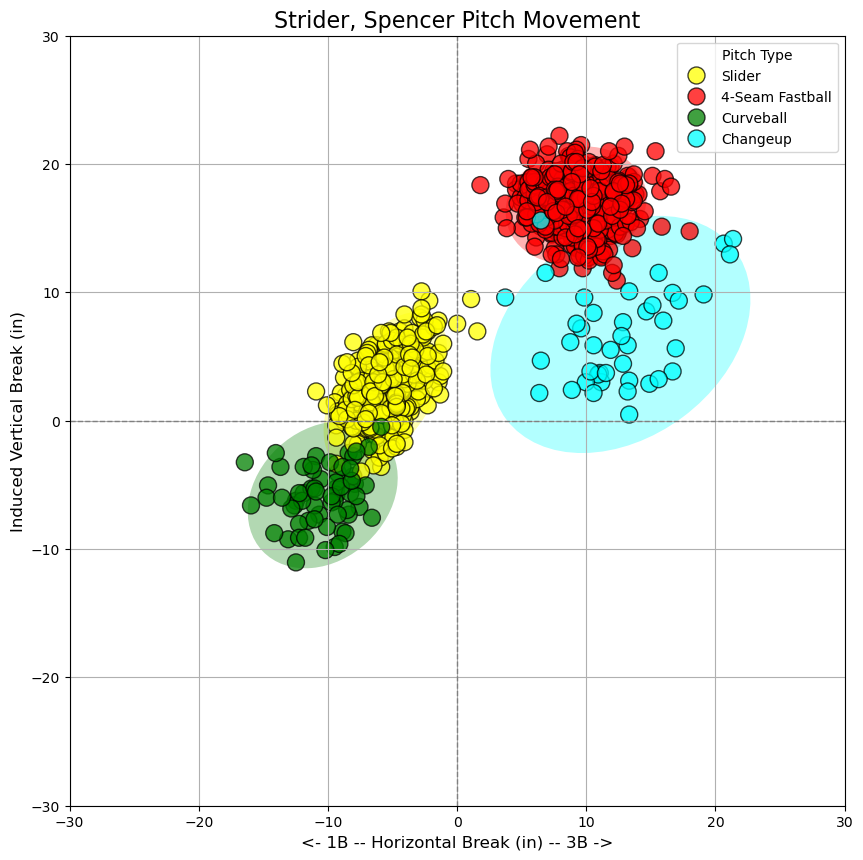

In [96]:
def plot_mlb_pitcher(pitcher):

    plotting_df = statcast_data[statcast_data['player_name'] == pitcher][['pitch_name', 'pfx_z', 'pfx_x']]
    plotting_df['pfx_z'] = plotting_df['pfx_z'] * 12
    plotting_df['pfx_x'] = plotting_df['pfx_x'] * (-12)
    plotting_df = plotting_df.dropna(subset = ['pitch_name'])
    
    color_map = {
        '4-Seam Fastball': 'red',
        'Sinker': 'darkorange',
        'Changeup': 'cyan',
        'Slider': 'yellow',
        'Curveball': 'green',
        'Split-Finger': 'brown',
        'Other': 'gray',
        'Sweeper': 'purple',
        'Cutter': 'teal', 
        'Screwball': 'pink'
    }

    plt.figure(figsize = (10, 10))
    ax = plt.gca()


    sns.scatterplot(
        data = plotting_df, 
        x = 'pfx_x',
        y = 'pfx_z',
        hue = 'pitch_name',
        palette = color_map,
        edgecolor = 'black',
        s = 150,
        alpha = 0.75,
        zorder = 1
    )

    def draw_ellipse(data, ax, color, label=None):
        if len(data) < 30:     
            return  
        
        data = np.array(data, dtype=float)
        
        cov = np.cov(data.T)
        mean = np.mean(data, axis=0)
        
        lambda_, v = np.linalg.eig(cov)
        lambda_ = np.sqrt(lambda_)
        
        scale_factor = 2.45
        ell = Ellipse(
            xy=mean,
            width=scale_factor * lambda_[0] * 2,
            height=scale_factor * lambda_[1] * 2,
            angle=np.rad2deg(np.arccos(v[0, 0])),
            edgecolor=color,
            facecolor=color,
            alpha=0.3,
            lw=0,
            zorder = 0
        )
        ax.add_patch(ell)

    # Draw ellipses for each pitch type
    for pitch_type, color in color_map.items():
        group = plotting_df[plotting_df['pitch_name'] == pitch_type]
        coords = group[['pfx_x', 'pfx_z']].dropna().to_numpy()
        display(coords)
        draw_ellipse(coords, ax, color)

    # Final plot formatting
    plt.title(f"{pitcher} Pitch Movement", fontsize=16)
    plt.xlabel("<- 1B -- Horizontal Break (in) -- 3B ->", fontsize=12)
    plt.ylabel("Induced Vertical Break (in)", fontsize=12)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.xticks(range(-30, 31, 10))
    plt.yticks(range(-30, 31, 10))
    plt.grid(True)
    plt.legend(title='Pitch Type')
    plt.show()
    
    
plot_mlb_pitcher('Strider, Spencer')

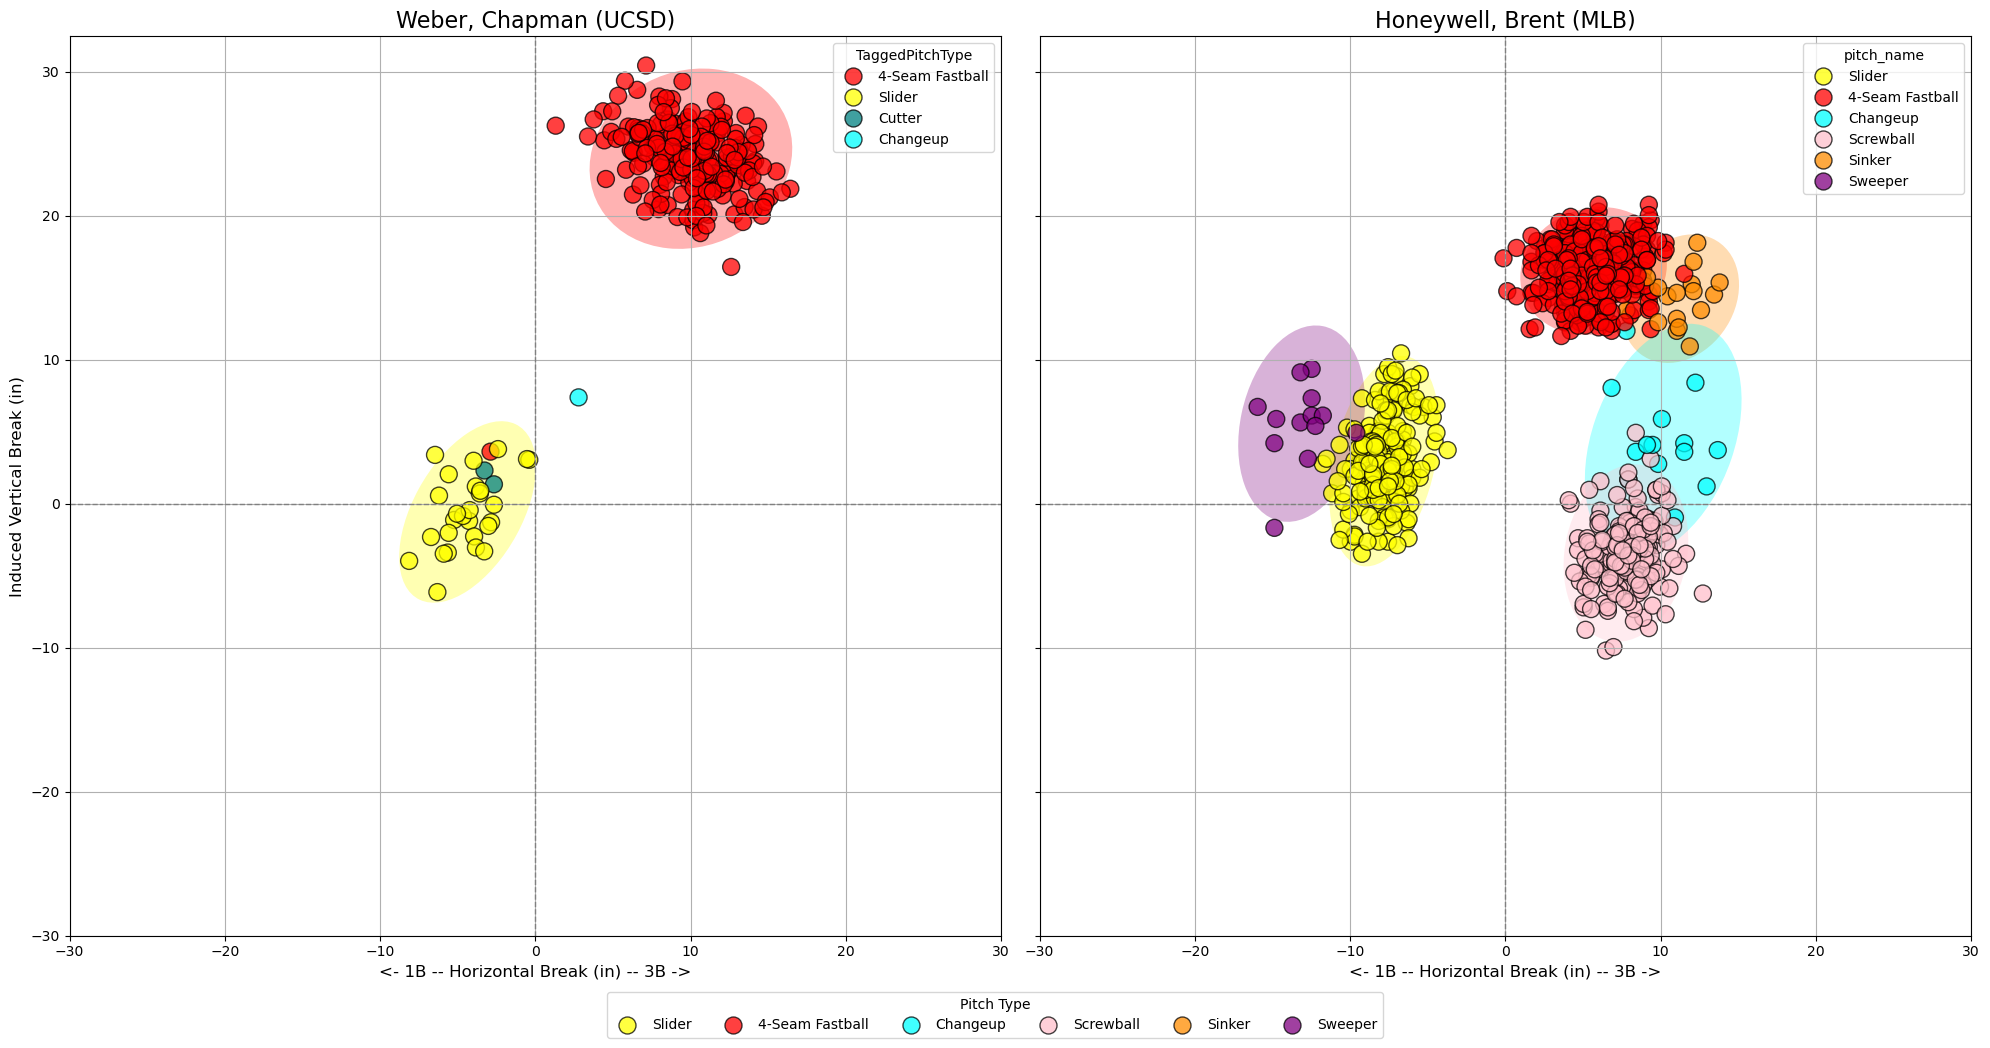

In [135]:
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

def compare_pitchers(ucsd_pitcher, mlb_pitcher, trackman, statcast_data):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)

    color_map = {
        '4-Seam Fastball': 'red',
        'Sinker': 'darkorange',
        'Changeup': 'cyan',
        'Slider': 'yellow',
        'Curveball': 'green',
        'Split-Finger': 'brown',
        'Other': 'gray',
        'Sweeper': 'purple',
        'Cutter': 'teal',
        'Screwball': 'pink',
        'Pitch Out': 'white',
        'Knuckleball': 'white',
        'TwoSeamFastBall': 'white',
        'Undefined': 'white'
    }

    def draw_ellipse(data, ax, color, label=None):
        if len(data) < 5:
            return
        data = np.array(data, dtype=float)
        cov = np.cov(data.T)
        mean = np.mean(data, axis=0)
        lambda_, v = np.linalg.eig(cov)
        lambda_ = np.sqrt(lambda_)
        scale_factor = 2.45  # 95% confidence
        ell = Ellipse(
            xy=mean,
            width=scale_factor * lambda_[0] * 2,
            height=scale_factor * lambda_[1] * 2,
            angle=np.rad2deg(np.arccos(v[0, 0])),
            edgecolor=color,
            facecolor=color,
            alpha=0.3,
            lw=0,
            zorder=0
        )
        ax.add_patch(ell)

    # ---- UCSD Pitcher ----
    ucsd_df = trackman[trackman['Pitcher'] == ucsd_pitcher][['TaggedPitchType', 'InducedVertBreak', 'HorzBreak']].copy()
    ucsd_df['HorzBreak'] = ucsd_df['HorzBreak'] * (-1)
    ax1 = axes[0]
    sns.scatterplot(
        data=ucsd_df, x='HorzBreak', y='InducedVertBreak',
        hue='TaggedPitchType', palette=color_map,
        edgecolor='black', s=150, alpha=0.75, ax=ax1, zorder=1
    )
    for pitch_type, color in color_map.items():
        group = ucsd_df[ucsd_df['TaggedPitchType'] == pitch_type]
        coords = group[['HorzBreak', 'InducedVertBreak']].dropna().to_numpy()
        draw_ellipse(coords, ax1, color)

    ax1.set_title(f"{ucsd_pitcher} (UCSD)", fontsize=16)
    ax1.set_xlabel("<- 1B -- Horizontal Break (in) -- 3B ->", fontsize=12)
    ax1.set_ylabel("Induced Vertical Break (in)", fontsize=12)
    ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax1.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax1.set_xticks(range(-30, 31, 10))
    ax1.set_yticks(range(-30, 31, 10))
    ax1.grid(True)

    # ---- MLB Pitcher ----
    mlb_df = statcast_data[statcast_data['player_name'] == mlb_pitcher][['pitch_name', 'pfx_z', 'pfx_x']].copy()
    mlb_df['pfx_z'] = mlb_df['pfx_z'] * 12
    mlb_df['pfx_x'] = mlb_df['pfx_x'] * (-12)
    mlb_df = mlb_df.dropna(subset=['pitch_name'])
    ax2 = axes[1]
    sns.scatterplot(
        data=mlb_df, x='pfx_x', y='pfx_z',
        hue='pitch_name', palette=color_map,
        edgecolor='black', s=150, alpha=0.75, ax=ax2, zorder=1
    )
    for pitch_type, color in color_map.items():
        group = mlb_df[mlb_df['pitch_name'] == pitch_type]
        coords = group[['pfx_x', 'pfx_z']].dropna().to_numpy()
        draw_ellipse(coords, ax2, color)

    ax2.set_title(f"{mlb_pitcher} (MLB)", fontsize=16)
    ax2.set_xlabel("<- 1B -- Horizontal Break (in) -- 3B ->", fontsize=12)
    ax2.set_ylabel("Induced Vertical Break (in)", fontsize=12)
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax2.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax2.set_xticks(range(-30, 31, 10))
    ax2.set_yticks(range(-30, 31, 10))
    ax2.grid(True)

    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, title='Pitch Type', loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05))
    plt.tight_layout()
    plt.show()


compare_pitchers('Weber, Chapman', 'Honeywell, Brent', trackman, statcast_data)

In [107]:
top10_df[top10_df['Similarity Rank'] == 1]

,Team Pitcher,Similar MLB Pitcher,Similarity Rank,Distance
0,"Cazares, Julian","Smith, Cade",1,2.350211
10,"Dalquist, Matthew","Thompson, Keegan",1,2.825474
20,"Davidson, Garrett","Hill, Jaden",1,1.565082
30,"Ernisse, Zach","Mattson, Isaac",1,2.405401
40,"Gregson, Niccolas","Herget, Kevin",1,1.279899
50,"Hasegawa, Sam","Montgomery, Mason",1,3.098777
60,"Huy, Nathan","Rasmussen, Drew",1,1.932304
70,"King, Devon","Hahn, Jesse",1,1.215358
80,"Marchetti, Landon","Cruz, Fernando",1,3.013424
90,"Murdock, Steele","Fernandez, Ryan",1,2.072634
